In [1]:
import sys 
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')

In [2]:
%load_ext autoreload
%autoreload 2
from relation import Scaling
from relation import Distribution
from relation import Analysis
from relation import RandomForest

In [3]:
a = Analysis(50,'140','')

In [4]:
a.distribution.z

0.032637493

In [5]:
df = a.get_dataframe()

Text(0, 0.5, '$V_{z}$')

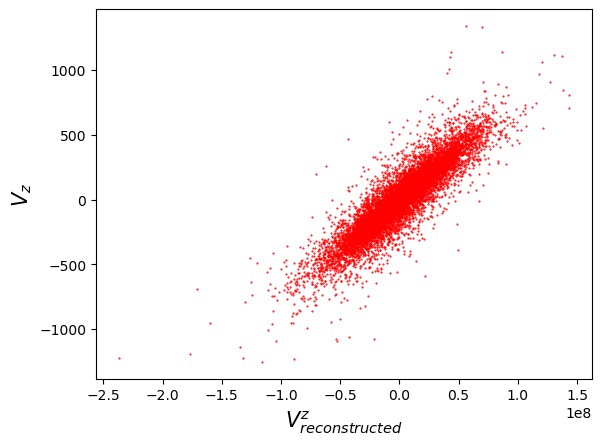

In [6]:
plt.plot(df['Vz'],df['Vlos'],'r.',markersize=1)
plt.xlabel("$V^z_{reconstructed}$",fontsize=15)
plt.ylabel("$V_{z}$",fontsize=15)

In [7]:
np.corrcoef(df['Vz'],df['Vlos'])[0,1]

0.9002092155230011

In [8]:
df.head()

,UID,x[kpc/h],y[kpc/h],z[kpc/h],x_pix,y_pix,i_sector,m500c[Msol/h],r500c[kpc/h],gas_frac,...,Vy,Vz,Vnet,vnet,Mstar,Mgas,Vlos,Yksz,M,Ytsz
0,0,208707.380,203892.310,349705.03,9714,6893,6,1.032820e+15,1239.470,0.122792,...,-7.024034e+07,-4.433932e+07,8.685351e+07,282.734776,4.223201e+13,1.811743e+14,-197.449,-11.521859,34.927744,-8.230696
1,1,314110.310,24347.102,278058.44,14620,15250,15,6.263050e+14,1049.090,0.116260,...,2.602357e+07,-5.794033e+07,8.453292e+07,420.658838,2.612479e+13,1.040203e+14,-256.902,-11.813518,34.427534,-9.135539
2,2,83776.258,206510.050,144915.31,3899,6771,4,7.927850e+14,1134.840,0.121408,...,6.671624e+06,-4.979367e+06,2.812165e+07,210.422788,2.543798e+13,1.375006e+14,-124.361,-12.259982,34.663248,-8.619792
3,3,183729.830,193320.660,332756.00,8551,7385,6,1.800290e+14,692.373,0.112743,...,4.130841e+07,8.060328e+06,9.136059e+07,1151.476184,6.765747e+12,2.899573e+13,-434.947,-12.564427,33.180814,-11.032434
4,4,327315.410,233257.000,209403.95,15235,5526,7,6.558460e+14,1065.330,0.114432,...,5.183772e+07,-4.228684e+07,7.715612e+07,283.361004,2.622119e+13,1.072140e+14,-111.475,-12.618172,34.473622,-9.126199


In [9]:
df.Vnet = df.Vnet.apply(lambda x: x/1e5)
df.Vz = df.Vz.apply(lambda x: x/1e5)
df.Mstar = df.Mstar.apply(lambda x: np.log(x))

In [21]:

project = RandomForest(df)
project.split_data()


Text(0, 0.5, 'Count')

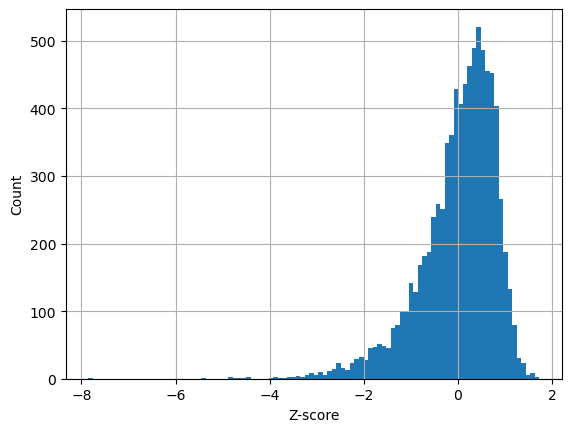

In [22]:
project.get_fit('train',zscore=True).hist(bins=100)
plt.xlabel('Z-score')
plt.ylabel('Count')

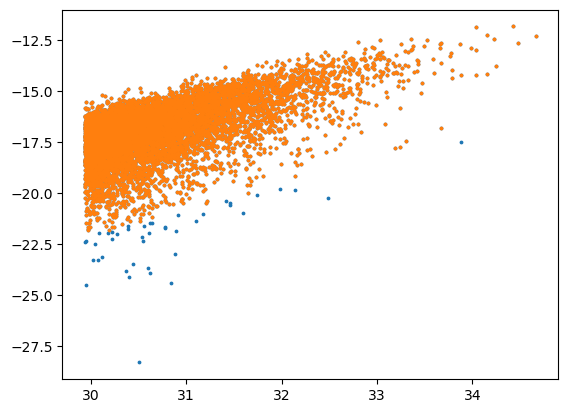

In [23]:
plt.scatter(project.X_train.M,project.y_train,s=3)
project.clean_data()
plt.scatter(project.X_train.M,project.y_train,s=3)

Using 0.25 quantile for Mass cut
Using 0.5 quantile for Mass cut
Using 0.75 quantile for Mass cut


Using 0.95 quantile for Mass cut


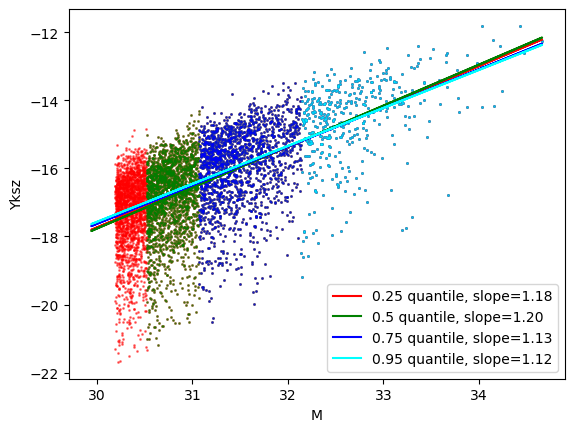

In [24]:
project.plot_fit(quantile=['Q1','Q2', 'Q3','Q4'])

In [25]:

# param_grid = {
#     'n_estimators': [50, 100, 200, 300],
#     'max_depth': [None, 10, 20,50,100],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_leaf_nodes' : [5,10,20,50,100,200,500]
# }

#project.find_best_hyperparameters(param_grid)

In [26]:
best = {'max_depth': 10,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 50}

In [27]:
project.best_hyperparameters = best

In [28]:
project.fit_with_hyperparameters(['M'], 'Yksz')
project.fit_with_hyperparameters(['M','Vz'], 'Yksz')
project.fit_with_hyperparameters(['M','Vlos'], 'Yksz')
#project.fit_with_hyperparameters(['M', 'Mstar'], 'Y')
#project.fit_with_hyperparameters(['M','Vz'], 'Y')
#project.fit_with_hyperparameters(['M','Vz', 'Vnet'], 'Y')
#project.fit_with_hyperparameters(['M','Vz', 'Vnet','Mstar'], 'Y')

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  

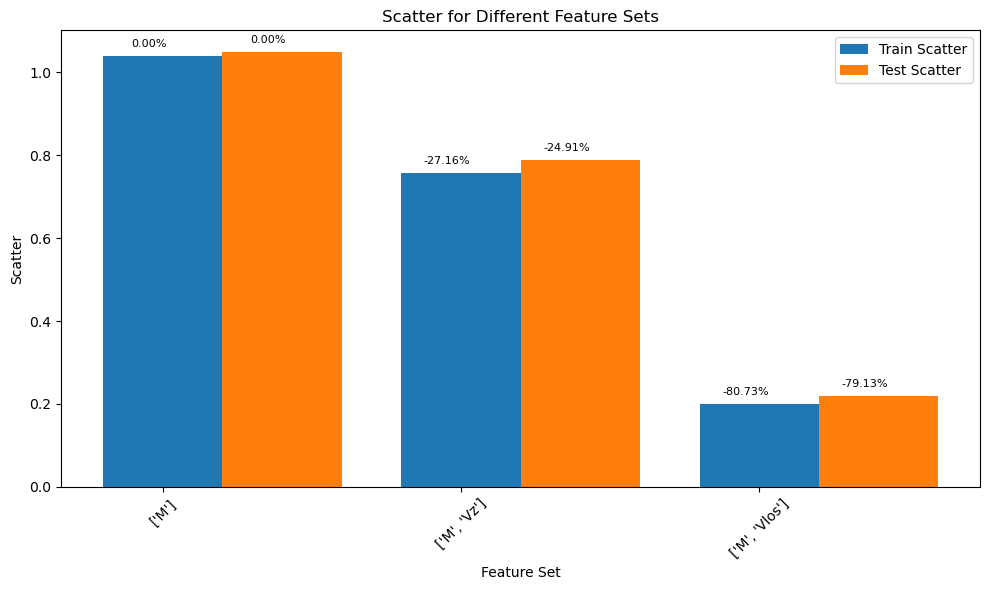

In [29]:

project.plot_scatter_statistics()


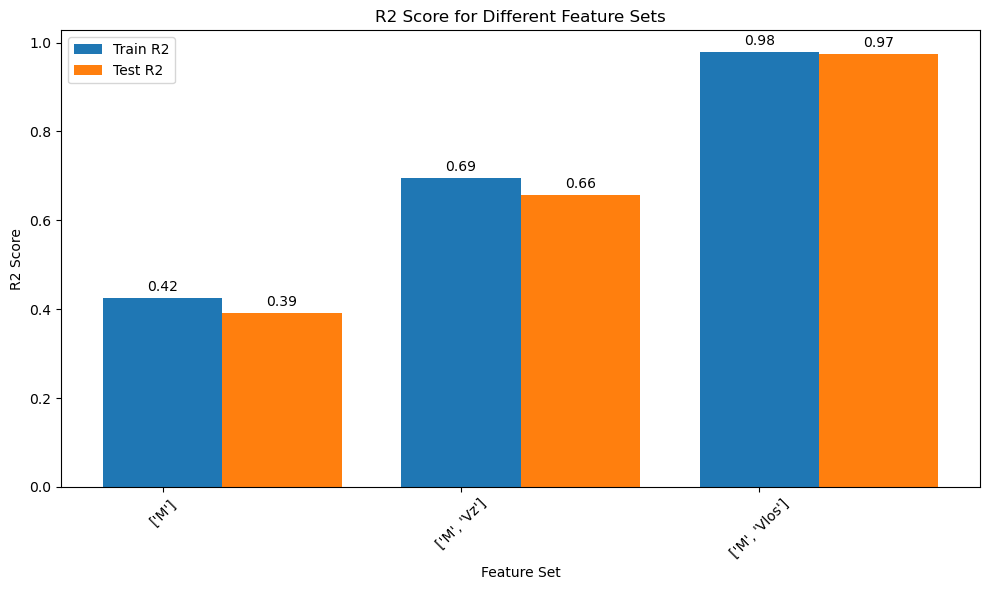

In [30]:
project.plot_r2_statistics()

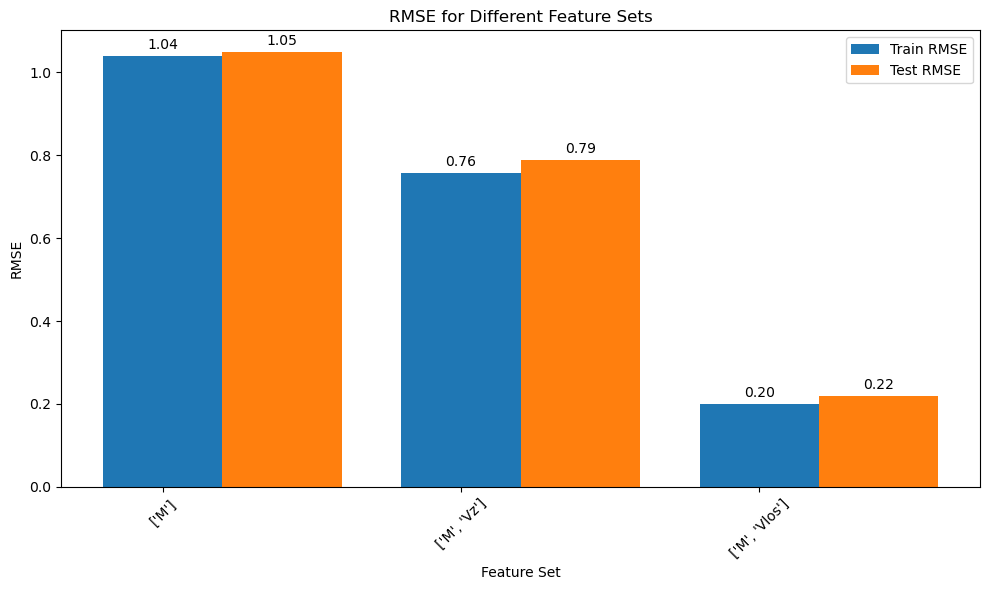

In [31]:
project.plot_RMSE()

In [71]:
from pysr import pysr
from sklearn.model_selection import train_test_split

In [81]:
df_,dfn = train_test_split(df, test_size=.1, random_state=42)

In [82]:
len(dfn)

1050

In [96]:
Yn = np.exp(dfn.Yksz.values,dtype=np.float64)

In [97]:
Mn = np.exp(dfn.M.values,dtype=np.float64)

In [98]:
Y_prime = Yn/Mn

In [102]:
ym_sr = dfn.Yksz.values/dfn.M.values
srdata = np.zeros((len(dfn),1))
srdata = dfn[['Vz']].values
names = ['Vz']
weights = dfn.M**0.5

In [103]:
equations = pysr(srdata, ym_sr, niterations=5,
        binary_operators=["+", "-", "*", "/", "^"],
        unary_operators=["neg", "square", "cube", "exp", "abs", "log", "log10"],
        weights=weights,
        #variable_names=(names),
        procs=4,
        loss="L1DistLoss()",
        equation_file='../Data/sr.csv')

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:89: FutureWarning: Calling `pysr` is deprecated. Please use `model = PySRRegressor(**params); model.fit(X, y)` going forward.
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!
